In [8]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import numba

from neurolib.models.wc import WCModel
from neurolib.control.optimal_control import oc_wc, cost_functions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


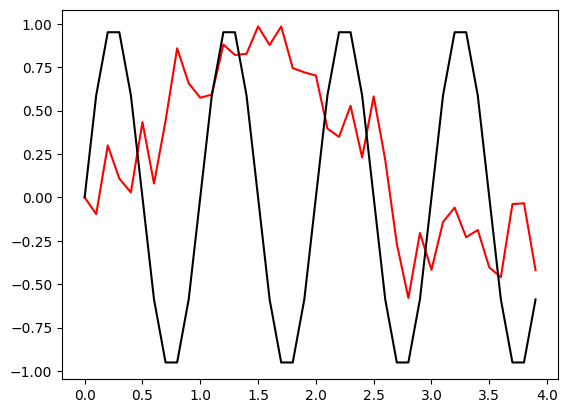

In [42]:
T, dt = 4, 0.1
time = np.arange(0,T,dt)
target_period = 1.

x = np.zeros((2,1,len(time)))
for t in range(1, x.shape[2]):
    x[0,0,t] = x[0,0,t-1] +(np.random.rand()-0.5)
x[1,0,:] = np.sin(2.*np.pi*time/target_period)

plt.plot(time, x[0,0,:], color="red")
plt.plot(time, x[1,0,:], color="black")
plt.show()

In [43]:
cost_matrix = np.ones((2,1))
interval = [0, len(time)]

Ff = cost_functions.fourier_cost(x, dt, target_period, cost_matrix, interval)
Ff_l = F_loc(x, target_period, dt)

print(Ff, Ff_l)

[[-3.32338872e-06]
 [-1.25000000e-03]] [-0.12533234]


In [49]:
def compute_gradient(x_, dx_, function, dt_, target_p):
    grad = np.zeros((x_.shape))
    x1_ = x_.copy()
    for n in range(x_.shape[0]):
        for v in range(x_.shape[1]):
            for t in range(x_.shape[2]):
                x1_[n,v,t] += dx_
                grad[n,v,t] = (function(x1_, dt_, target_p) - function(x_, dt_, target_p))[v,t]/dx_
                x1_[n,v,t] -= dx_
                
    return grad

def compute_gradient_F(x_, dx_, function, dt_, target_p):
    grad = np.zeros((x_.shape[0], x_.shape[1]))
    x1_ = x_.copy()
    for n in range(x_.shape[0]):
        for v in range(x_.shape[1]):
            for t in range(x_.shape[2]):
                x1_[n,v,t] += dx_
                grad[n,v] = (function(x1_, dt_, target_p) - function(x_, dt_, target_p))[n,v]/dx_
                x1_[n,v,t] -= dx_

    return grad


def mean_loc(x_):
    xmean = np.zeros((x_.shape[1], x_.shape[2]))
    for v in range(x_.shape[1]):
        for t in range(x_.shape[2]):
            for n in range(x_.shape[0]):
                xmean[v,t] += x_[n,v,t]

            xmean[v,t] /= x_.shape[0]

    return xmean

@numba.njit
def sum_x(x_):
    sumx = np.zeros((x_.shape[1], x_.shape[2]))
    for n in range(x_.shape[0]):
        for v in range(x_.shape[1]):
            for t in range(x_.shape[2]):
                sumx[v,t] += x_[n,v,t]

    return sumx

@numba.njit
def df_dx(x_, dt_, target_p):
    df_dx = np.zeros((x_.shape))
    omega = 2. * np.pi * dt_/ target_p
    for n in range(x_.shape[0]):
        for v in range(x_.shape[1]):
            for t in range(x_.shape[2]):
                for t1 in range(x_.shape[2]):
                    df_dx[n,v,t] -= x_[n,v,t] * x_[n,v,t1] * np.cos(omega*(t-t1)) * dt_

                df_dx[n,v,t] -= x_[n,v,t]**2

    return df_dx# / (x_.shape[0] * (x_.shape[2] * dt_)**2)


@numba.njit
def f_loc(x_, dt_, target_p):
    f = np.zeros((x_.shape))
    omega = 2. * np.pi * dt_/ target_p

    for t in range(x_.shape[2]):
        for t1 in range(x_.shape[2]):
            f[t] += x_[t] * x_[t1] * np.cos(omega*(t-t1)) * dt_

    return f

def F_loc(x_, target_p, dt_):
    cost = 0.
    omega = 2.*np.pi*dt_/target_p
    for t in range(x_.shape[2]):
        for t1 in range(x_.shape[2]):
            cost += x_[t] * x_[t1] * np.cos(omega*(t-t1)) * dt_*dt_

    return cost

In [50]:
F = F_loc(x, target_period, dt)
f = f_loc(x, dt, target_period)

print(F)
print(np.sum(f)*dt)

df = df_dx(x, dt, target_period)
df_num = compute_gradient(x, 1e-3, f_loc, dt, target_period)

[-0.12533234]
-0.12533233887246173


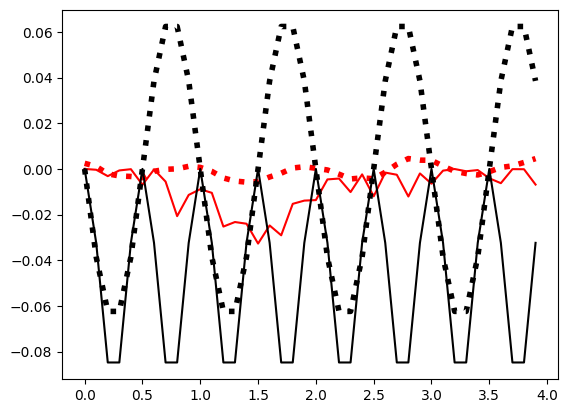

In [51]:


plt.plot(time, df[0,0,:], color="red")
plt.plot(time, df_num[0,0,:], color="red", linewidth=4, linestyle=":")
plt.plot(time, df[1,0,:], color="black")
plt.plot(time, df_num[1,0,:], color="black", linewidth=4, linestyle=":")
plt.show()

In [21]:
def f1(func, period, dt):
    int = 0.
    for t in range(func.shape[0]):
        int += func[t] * np.exp(-2.*np.pi*complex(0,1)*t*dt/period)
    return np.abs(int)**2

def f2(func, period, dt):
    int0 = 0.
    int1 = 0.
    for t in range(func.shape[0]):
        int0 += func[t] * np.cos(-2.*np.pi*t*dt/period)
        int1 += func[t] * np.sin(-2.*np.pi*t*dt/period)
    return int0**2 + int1**2

def f3(func, period, dt):
    omega = 2. * np.pi * dt / period
    int = 0.
    for t1 in range(func.shape[0]):
        for t2 in range(func.shape[0]):
            int += func[t1]*func[t2] * np.cos(omega*(t1-t2))

    return int

In [23]:
testfunc = np.sin(time)

print(f1(testfunc, target_period, dt))
print(f2(testfunc, target_period, dt))
print(f3(testfunc, target_period, dt))


1.4344126268178996
1.4344126268179003
1.4344126268179018
